In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras import models, layers, callbacks, optimizers, regularizers
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [2]:
def Split(x, y, seed=0):
    a = int(0.8 * x.shape[0])
    b = int(0.9 * x.shape[0])
    index = np.arange(a)
    np.random.seed(seed)
    np.random.shuffle(index)
    return x[:a][index], y[:a][index], x[a:b], y[a:b], x[b:], y[b:]

In [3]:
class StandardScaler:
    def __init__(self, data):
        self.mean = np.mean(data)
        self.std = np.std(data)

    def transform(self, data):
        return (data - self.mean) / self.std

    def inverse_transform(self, data):
        return data * self.std + self.mean

In [4]:
def Net(shape):
    model = models.Sequential([
        layers.Input(shape=shape),
        layers.TimeDistributed(layers.Conv1D(32, kernel_size=4, padding='same')),
        layers.LeakyReLU(0.2),
        layers.TimeDistributed(layers.MaxPool1D()),
        layers.TimeDistributed(layers.Conv1D(32, kernel_size=2, padding='same')),
        layers.LeakyReLU(0.2),
        layers.TimeDistributed(layers.MaxPool1D()),
        layers.TimeDistributed(layers.Flatten()),
        layers.LSTM(64, return_sequences=True),
        layers.LSTM(64),
        layers.Dense(32, kernel_initializer='he_uniform'),
        layers.LeakyReLU(0.2),
        layers.Dense(1, kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2())
    ])
    return model  

In [5]:
df = pd.read_csv('bdi.csv', parse_dates=['date'], index_col=['date'])
df

,bdi
date,
2000-01-01,1319.0
2000-01-02,NaN
2000-01-03,NaN
2000-01-04,1320.0
2000-01-05,1329.0
...,...
2020-10-05,2071.0
2020-10-06,2097.0
2020-10-07,2044.0


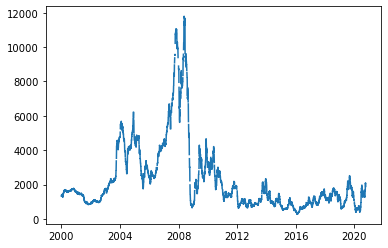

In [6]:
plt.plot(df)

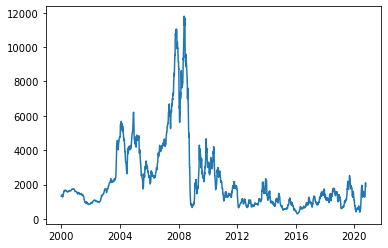

In [7]:
df.fillna(method='ffill', inplace=True)
plt.plot(df)

In [8]:
data = df.values

In [9]:
y = np.array([data[i] for i in range(90, data.shape[0])]).reshape(-1,1)
x = np.array([data[i-30:i] for i in range(30, data.shape[0])]).reshape(-1,30,1)
x = np.array([x[i-61:i] for i in range(61, x.shape[0]+1)])

In [10]:
x_train, y_train, x_val, y_val, x_test, y_test = Split(x, y, seed=42)

In [11]:
scaler = StandardScaler(y_train)
x_train = scaler.transform(x_train)
y_train = scaler.transform(y_train)
x_val = scaler.transform(x_val)
y_val = scaler.transform(y_val)
x_test = scaler.transform(x_test)

In [12]:
model = Net([x.shape[1], x.shape[2], x.shape[3]])
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 61, 30, 32)        160       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 61, 30, 32)        0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 61, 15, 32)        0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 61, 15, 32)        2080      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 61, 15, 32)        0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 61, 7, 32)         0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 61, 224)           0

In [13]:
filepath = 'checkpoint.h5'
checkpoint = callbacks.ModelCheckpoint(filepath=filepath, monitor='val_loss', save_best_only=True)
h0 = model.fit(x_train, y_train, validation_data=(x_val, y_val), 
               batch_size=128, epochs=100, callbacks=[checkpoint], shuffle=True)
model = models.load_model(filepath)
model.compile(loss='mse', optimizer=optimizers.SGD(learning_rate=0.001, momentum=0.9))
h1 = model.fit(x_train, y_train, validation_data=(x_val, y_val), 
               batch_size=128, epochs=100, callbacks=[checkpoint], shuffle=True)
model = models.load_model(filepath)

Epoch 1/100
47/47 [==============================] - 5s 110ms/step - loss: 0.1328 - val_loss: 0.0345
Epoch 2/100
47/47 [==============================] - 1s 21ms/step - loss: 0.0481 - val_loss: 0.0320
Epoch 3/100
47/47 [==============================] - 1s 21ms/step - loss: 0.0400 - val_loss: 0.0291
Epoch 4/100
47/47 [==============================] - 1s 21ms/step - loss: 0.0346 - val_loss: 0.0265
Epoch 5/100
47/47 [==============================] - 1s 21ms/step - loss: 0.0305 - val_loss: 0.0241
Epoch 6/100
47/47 [==============================] - 1s 21ms/step - loss: 0.0273 - val_loss: 0.0220
Epoch 7/100
47/47 [==============================] - 1s 20ms/step - loss: 0.0242 - val_loss: 0.0199
Epoch 8/100
47/47 [==============================] - 1s 21ms/step - loss: 0.0228 - val_loss: 0.0180
Epoch 9/100
47/47 [==============================] - 1s 21ms/step - loss: 0.0198 - val_loss: 0.0164
Epoch 10/100
47/47 [==============================] - 1s 20ms/step - loss: 0.0175 - val_loss: 0.014

47/47 [==============================] - 1s 20ms/step - loss: 0.0012 - val_loss: 7.8986e-04
Epoch 82/100
47/47 [==============================] - 1s 21ms/step - loss: 0.0011 - val_loss: 7.6201e-04
Epoch 83/100
47/47 [==============================] - 1s 21ms/step - loss: 0.0014 - val_loss: 7.5453e-04
Epoch 84/100
47/47 [==============================] - 1s 21ms/step - loss: 0.0011 - val_loss: 7.3883e-04
Epoch 85/100
47/47 [==============================] - 1s 21ms/step - loss: 9.7400e-04 - val_loss: 7.2561e-04
Epoch 86/100
47/47 [==============================] - 1s 21ms/step - loss: 0.0011 - val_loss: 6.8846e-04
Epoch 87/100
47/47 [==============================] - 1s 20ms/step - loss: 0.0011 - val_loss: 7.3688e-04
Epoch 88/100
47/47 [==============================] - 1s 20ms/step - loss: 0.0010 - val_loss: 7.3083e-04
Epoch 89/100
47/47 [==============================] - 1s 21ms/step - loss: 9.6998e-04 - val_loss: 6.8110e-04
Epoch 90/100
47/47 [==============================] - 1s 20m

47/47 [==============================] - 1s 21ms/step - loss: 7.4180e-04 - val_loss: 5.6318e-04
Epoch 57/100
47/47 [==============================] - 1s 20ms/step - loss: 7.4962e-04 - val_loss: 5.5810e-04
Epoch 58/100
47/47 [==============================] - 1s 20ms/step - loss: 7.4033e-04 - val_loss: 5.6163e-04
Epoch 59/100
47/47 [==============================] - 1s 21ms/step - loss: 7.3961e-04 - val_loss: 5.6055e-04
Epoch 60/100
47/47 [==============================] - 1s 20ms/step - loss: 7.3835e-04 - val_loss: 5.5799e-04
Epoch 61/100
47/47 [==============================] - 1s 20ms/step - loss: 7.3774e-04 - val_loss: 5.6212e-04
Epoch 62/100
47/47 [==============================] - 1s 20ms/step - loss: 7.3879e-04 - val_loss: 5.5960e-04
Epoch 63/100
47/47 [==============================] - 1s 21ms/step - loss: 7.3854e-04 - val_loss: 5.5782e-04
Epoch 64/100
47/47 [==============================] - 1s 21ms/step - loss: 7.4125e-04 - val_loss: 5.5620e-04
Epoch 65/100
47/47 [============

In [14]:
predict = model.predict(x_test)
predict = scaler.inverse_transform(predict)

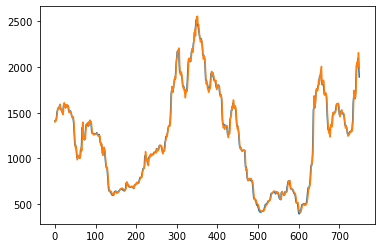

In [15]:
plt.plot(y_test)
plt.plot(predict)

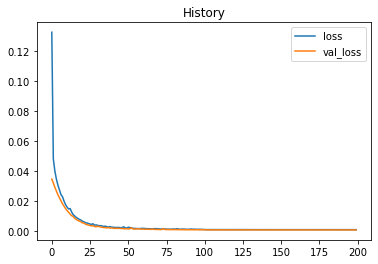

In [16]:
plt.plot(h0.history['loss'] + h1.history['loss'], label='loss')
plt.plot(h0.history['val_loss'] + h1.history['val_loss'], label='val_loss')
plt.title(f'History')
plt.legend()
plt.show()

In [17]:
metrics.mean_absolute_error(y_test, predict)

25.273983235677083